<a href="https://colab.research.google.com/github/lichkim/VQE_Summer_Internship/blob/master/tutorial_2_multi_qubits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U pennylane
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
import tensorflow as tf
from itertools import product

2023-08-01 09:08:02.340429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
qml.about()

Name: PennyLane
Version: 0.31.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml
Required-by: PennyLane-Cirq, PennyLane-Lightning, PennyLane-qiskit, PennyLane-SF

Platform info:           Linux-5.15.0-78-generic-x86_64-with-glibc2.35
Python version:          3.10.4
Numpy version:           1.22.4
Scipy version:           1.9.0
Installed devices:
- lightning.qubit (PennyLane-Lightning-0.31.0)
- default.gaussian (PennyLane-0.31.0)
- default.mixed (PennyLane-0.31.0)
- default.qubit (PennyLane-0.31.0)
- default.qubit.autograd (PennyLane-0.31.0)
- default.qubit.jax (PennyLane-0.31.0)
- default.qubit.tf (PennyLane-0.31.0)
- default.qubit.torch (PennyLane-0.31.0)
- default.qu

In [3]:
# !pip install tensorflow=='2.12'
tf.__version__  #tensorflow version이 2.13.0이면 문제 발생하니까 2.12로 바꿔서 설치하세요


'2.12.0'

In [4]:
class Sigma:
    def __init__(self, *args):
            '''
            Sigma class generates algebraic primitives required to compute the system of implicit ODEs for Euler angles.
            '''
            self.string = [i for i in args]
            self.order = len(args)
            self.digit = sum([args[i]*4**(self.order-i-1) for i in range(len(args))])
            self.pauli = tf.constant([
                 [[-1j/2,0],[0,-1j/2]],[[0, 1j/2],[1j/2, 0]],[[0, -1/2],[1/2, 0]],[[1j/2, 0],[0, -1j/2]]
                      ],dtype=tf.complex64,shape=(4,2,2))
            self.__struct_const_0 = tf.constant(
                [
                    np.zeros([4,4]),
                    [[0.0, 0.0, 0.0, 0.0],[0.0, 0.0, 0.0, 0.0],[0.0, 0.0, 0.0, -1.0],[0.0, 0.0, 1.0, 0.0]],
                    [[0.0, 0.0, 0.0, 0.0],[0.0, 0.0, 0.0, 1.0],[0.0, 0.0, 0.0, 0.0],[0.0, -1.0, 0.0, 0.0]],
                    [[0.0, 0.0, 0.0, 0.0],[0.0, 0.0, -1.0, 0.0],[0.0, 1.0, 0.0, 0.0],[0.0, 0.0, 0.0, 0.0]]
                    ], dtype=tf.complex64
            )
            self.__struct_const_1 = tf.constant(
                [
                    -1j*np.eye(4),
                    -1j*np.array([[0.0, 1.0, 0.0, 0.0],[1.0, 0.0, 0.0, 0.0],[0.0, 0.0, 0.0, 0.0],[0.0, 0.0, 0.0, 0.0]]),
                    -1j*np.array([[0.0, 0.0, 1.0, 0.0],[0.0, 0.0, 0.0, 0.0],[1.0, 0.0, 0.0, 0.0],[0.0, 0.0, 0.0, 0.0]]),
                    -1j*np.array([[0.0, 0.0, 0.0, 1.0],[0.0, 0.0, 0.0, 0.0],[0.0, 0.0, 0.0, 0.0],[1.0, 0.0, 0.0, 0.0]])
                    ], dtype=tf.complex64
            )
            self.__vector = tf.constant([
                [1,0,0,0],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1]], dtype=tf.float32
            )
            self.index_perm = list(range(0,self.order*2,2)) + list(range(1,self.order*2+1,2))
            self.fundamental = self.rep_fundamental()
            self.adjoint = self.rep_adjoint()
            self.fundamental_z = tf.eye(2,dtype=tf.complex64)
            for i in range(1,self.order):
                self.fundamental_z = tf.tensordot(self.fundamental_z,tf.eye(2,dtype=tf.complex64),axes=0)
            self.fundamental_z = tf.transpose(self.fundamental_z,perm=self.index_perm)
            self.adjoint_z = tf.eye(4,dtype=tf.float32)
            for i in range(1,self.order):
                self.adjoint_z = tf.tensordot(self.adjoint_z,tf.eye(4,dtype=tf.float32),axes=0)
            self.adjoint_z = tf.transpose(self.adjoint_z,perm=self.index_perm)
            self.adjoint_square = tf.tensordot(self.adjoint,self.adjoint,axes=self.order)
            self.adj_vec = self.adj_vector()

    def rep_fundamental(self):
        index = self.string
        ret = self.pauli[index[0]]
        for i in range(1,len(index)):
            ret = 2j*tf.tensordot(ret,self.pauli[index[i]],axes=0)
        return tf.transpose(ret,perm=self.index_perm)


    def rep_adjoint(self):
        return tf.transpose(tf.cast(self.__rep_adjoint(self.string),dtype=tf.float32),perm=self.index_perm)

    def __rep_adjoint(self,sigma,center=False,grade=False):
        order = len(sigma)
        if grade:
            ret = self.__struct_const_1[sigma[0]]
        else:
            ret = self.__struct_const_0[sigma[0]]

        if order > 1:
            if grade:
                ret = 1.j* (
                    tf.tensordot(self.__rep_adjoint(sigma[0:order-1],center=True,grade=True),  self.__rep_adjoint([sigma[order-1]],center=True,grade=True),axes=0) +
                    tf.tensordot(self.__rep_adjoint(sigma[0:order-1],center=True,grade=False), self.__rep_adjoint([sigma[order-1]],center=True,grade=False),axes=0)
                    )
            else:
                ret = 1.j* (
                    tf.tensordot(self.__rep_adjoint(sigma[0:order-1],center=True,grade=True),  self.__rep_adjoint([sigma[order-1]],center=True,grade=False),axes=0) +
                    tf.tensordot(self.__rep_adjoint(sigma[0:order-1],center=True,grade=False), self.__rep_adjoint([sigma[order-1]],center=True,grade=True),axes=0)
                    )


        return ret

    def adj_vector(self):
        index = self.string
        ret = self.__vector[index[0]]
        for i in range(1,len(index)):
            ret = tf.tensordot(ret,self.__vector[index[i]],axes=0)
        return ret
    @tf.function
    def exp_fundamental(self,x):
        s = tf.cast(tf.math.sin(x/2),tf.complex64)
        c = tf.cast(tf.math.cos(x/2),tf.complex64)
        return tf.tensordot(c, self.fundamental_z,axes=0) + tf.tensordot(2*s,  self.fundamental,axes=0)
    @tf.function
    def exp_adjoint(self,x):
        return self.adjoint_z + tf.tensordot(tf.math.sin(x), self.adjoint,axes=0) + tf.tensordot((1 - tf.math.cos(x)), self.adjoint_square,axes=0)

In [5]:
class Euler():
    def __init__(self, order):
        self.order = order
        self.basis = np.array(list(product([0,1,2,3], repeat = order)))
        self.toral = np.array(list(product([0,3], repeat = order)))
        self.kprime = self.__kprime(order)
        self.aprime = self.__aprime(order)
        self.k = self.__k(order)
        self.a = self.__a(order)
        self.kak = np.concatenate((self.k,self.a,self.k),axis=0)
        self.generator = self.__generator(order)
        self.dim = len(self.kak)

    def __kak(self,order):
        if order == 1:
            return np.array([[3],[1],[3]])
        else:
            # return self.__a(order-1)
            return np.concatenate((self.__k(order),self.__a(order),self.__k(order)),axis=0)

    def __kprime(self,order):
        if order == 1:
            return np.array([],dtype=np.int32)
        else:
            # print(self.__kak(order-1))
            return np.insert(self.__kak(order-1),0,0,axis=1)

    def __aprime(self,order):
        if order == 1:
            return np.array([],dtype=np.int32)
        else:
            return np.insert(np.array(list(product([0,3], repeat = order-1))),0,3,axis=1)

    def __k(self,order):
        if order == 1:
            return np.array([[3]])
        else:
            # print(self.kprime)
            # return np.concatenate((self.kprime,self.aprime,self.kprime),axis=0)
            return np.concatenate((self.__kprime(order),self.__aprime(order),self.__kprime(order)),axis=0)

    def __a(self,order):
        if order == 1:
            return np.array([[1]])
        else:
            return np.insert(np.array(list(product([0,3], repeat = order-1))),0,1,axis=1)

    def __generator(self,order):
        if order == 1:
            return np.array([[1],[3]])
        else:
            ret = np.insert(self.__generator(order-1),0,0,axis=1)
            return np.concatenate((ret,self.__a(order),self.__aprime(order)),axis=0)

In [6]:
dev = qml.device("default.qubit", wires=1)
def circuit(params, wires=0):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires) #ansatz

##### qml.Hamiltonian: Hamiltonian은 다른 operator들의 linear combination으로 구성됩니다. 즉, $\sum_{k=0}^{n-1} c_{k}O_{k}$입니다. 여기서 $c_{k}$는 훈련시킬 수 있는 parameter입니다.

In [7]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)  #define Hamiltonian

@qml.qnode(dev, interface="autograd") #parameter shift
def cost_fn(params):    #정의한 hamiltonian에 대한 기댓값을 구합니다.
    circuit(params)
    return qml.expval(H)

In [8]:
init_params = np.array([3.97507603, 3.00854038], requires_grad=True)

In [9]:
max_iterations = 500
conv_tol = 1e-06
#step_size = 0.1 #learning rate

#### Pennylane의 GradientDescentOptimizer 클래스를 불러와 최적화 하기

##### GradientDescentOptimzer의 [document](https://docs.pennylane.ai/en/stable/code/api/pennylane.GradientDescentOptimizer.html)

##### 일반적인 GradientDescent 방식으로 최적화합니다. 아래의 식을 따릅니다. $$x^{\left(t+1\right)} = x^{\left(t\right)} - \eta\nabla f\left(x^{\left(t\right)}\right)$$ 여기서 $\eta$는 유저가 인자 stepsize를 통해 정의할 수 있습니다.

In [10]:
#opt = qml.GradientDescentOptimizer(stepsize=step_size)
opt = qml.GradientDescentOptimizer(stepsize=0.1)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.48118828 Ha,  Convergence parameter = 0.09598332 Ha
Iteration = 20,  Energy = -0.46381708 Ha,  Convergence parameter = 0.08210876 Ha
Iteration = 40,  Energy = -1.40651648 Ha,  Convergence parameter = 0.00272091 Ha
Iteration = 60,  Energy = -1.41419617 Ha,  Convergence parameter = 0.00000620 Ha

Final value of the energy = -1.41421077 Ha
Number of iterations =  66


#### Pennylane의 QNGOptimizer 클래스를 불러와 최적화하기

##### QNGOptimzer의 [document](https://docs.pennylane.ai/en/stable/code/api/pennylane.QNGOptimizer.html)

##### Fubini-Study metric tensor에 diagonal 혹은 block-diagonal 근사를 하여 learning rate를 지속적으로 수정하는 optimizer입니다.

##### QNG optimizer는 Fubini-Study metric tensor $g$의 pseudo-inverse에 기반한 step과 parameter에 영향을 받는 learning rate를 사용합니다. $$x^{\left(t+1\right)} = x^{\left(t\right)} - \eta g\left(f\left(x^{\left(t\right)}\right)\right)^{-1} \nabla f\left(x^{\left(t\right)}\right)$$ 여기서 $f\left(x^{\left(t\right)}\right) = \bra{0}U\left(x^{\left(t\right)}\right)^{\dagger}\hat{B}U\left(x^{\left(t\right)}\right)\ket{0}$는 variational quantum circuit $U\left(x^{\left(t\right)}\right)$에서 측정된 observable의 기댓값입니다.

##### Variational Quantum Circuit으로 표현된 Quantum Node를 생각해봅시다. $$ U\left(\theta\right) = W\left(\theta_{i+1},\cdots,\theta_{N}\right)X\left(\theta_{i}\right)V\left(\theta_{1},\cdots,\theta_{i-1}\right)$$ 여기서 모든 parametrized gate들은 $X\left(\theta_{i}\right) = e^{i\theta_{i}K_{i}}$로 표현될 수 있습니다.<br>

##### 즉, 게이트 $K_{i}$가 $i$번째 파라미터에 대응하는 parameterized operation $X\left(\theta_{i}\right)$의 *generator*입니다.<br>

In [11]:
#opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")
opt = qml.QNGOptimizer(stepsize=0.1, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = -0.01070497 Ha,  Convergence parameter = 0.58787657 Ha

Final value of the energy = -1.41421347 Ha
Number of iterations =  11


In [12]:
@qml.qnode(dev, interface="tf")
def tf_cost_fn(params):
    circuit(params)
    return qml.expval(H)

2023-08-01 09:08:07.585337: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
tf.random.set_seed(42)
n_neuron = 8 #hidden layer

nn_vars = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)), #input neuron 1
    tf.keras.layers.Dense(n_neuron, activation='tanh'),
    tf.keras.layers.Dense(2) #output
])

##### Tensorflow를 이용해 Classical하게 최적화하기

In [14]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
optim = tf.keras.optimizers.Adam(learning_rate=0.01)

nn_param_history = [nn_vars(tf.constant([1.]))]
nn_cost_history = []

for epoch in range(1,max_iterations+1):
    with tf.GradientTape() as tape: #autodiff(backward)

        loss = tf_cost_fn(*nn_vars(tf.constant([1.])))
    if len(nn_cost_history) > 0:
      conv = tf.abs(nn_cost_history[-1] - loss)
    else:
      conv = loss
    nn_cost_history.append(loss)
    gradients = tape.gradient(loss, nn_vars.trainable_variables);
    optim.apply_gradients(zip(gradients, nn_vars.trainable_variables));
    nn_param_history.append(nn_vars(tf.constant([1.])))
    # conv = tf.abs(tf_cost_fn(*nn_vars(tf.constant([1.]))) - loss)
    if conv <= conv_tol:
        break
    print("epoch: {}, loss: {}, convergence {}".format(epoch, loss, conv))

epoch: 1, loss: 0.2851590689849563, convergence 0.2851590689849563
epoch: 2, loss: 0.2026917338724838, convergence 0.0824673351124725
epoch: 3, loss: 0.12866993852360026, convergence 0.07402179534888353
epoch: 4, loss: 0.0643721334287164, convergence 0.06429780509488386
epoch: 5, loss: 0.010237663373732497, convergence 0.054134470054983896
epoch: 6, loss: -0.03480051402874046, convergence 0.045038177402472956
epoch: 7, loss: -0.07383163390468395, convergence 0.03903111987594349
epoch: 8, loss: -0.11170225460256533, convergence 0.037870620697881385
epoch: 9, loss: -0.15363880123203671, convergence 0.04193654662947138
epoch: 10, loss: -0.20361567042457596, convergence 0.04997686919253924
epoch: 11, loss: -0.26392321418429854, convergence 0.06030754375972258
epoch: 12, loss: -0.33550113983948027, convergence 0.07157792565518173
epoch: 13, loss: -0.41824660603410335, convergence 0.08274546619462309
epoch: 14, loss: -0.511175590476344, convergence 0.09292898444224063
epoch: 15, loss: -0.612

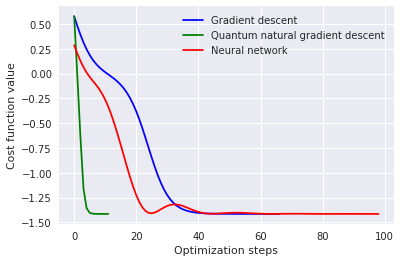

In [15]:
plt.style.use("seaborn")
plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qngd_cost_history, "g", label="Quantum natural gradient descent")
plt.plot(nn_cost_history, "r", label="Neural network")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

In [16]:
#multi-variable은 구현이 어려움
def pauli_string(sigma): #rotation operator 만들어줌
    '''
    translates sigma strings in Euler class to Pauli words in Pennylane.
    '''
    pauli_alphabet = ["I","X","Y","Z"]
    return "".join([pauli_alphabet[sigma[j]] for j in range(len(sigma))])
def generate_qc_sk(eu):
    '''
    generates a universal parametric quantum circuit by using the KAK decomposition.
    '''
    pauli_ps = [pauli_string(s) for s in eu.basis]
    dim = len(pauli_ps)

    def qc_sk(theta):
        for i in range(eu.dim):
            qml.PauliRot(theta[i], pauli_ps[i], wires = list(range(eu.order))) #pauli rotation, pauli state
    return qc_sk

In [17]:
def x_up(qw,adjoint=False):
    if adjoint:
        qml.adjoint(qml.Hadamard(qw)) #|+> = |0> - H
    else:
        qml.Hadamard(wires=qw)

def x_down(qw,adjoint=False):
    if adjoint:
        qml.adjoint(qml.Hadamard(qw))
        qml.adjoint(qml.PauliX(qw))
    else:
        qml.PauliX(wires=qw)
        qml.Hadamard(wires=qw)

def y_up(qw,adjoint=False):
    if adjoint:
        qml.adjoint(qml.S(wires=qw))
        qml.adjoint(qml.Hadamard(wires=qw))
    else:
        qml.Hadamard(wires=qw)
        qml.S(wires=qw)

def y_down(qw,adjoint=False):
    if adjoint:
        qml.adjoint(qml.S(wires=qw))
        qml.adjoint(qml.Hadamard(wires=qw))
        qml.adjoint(qml.PauliX(wires=qw))
    else:
        qml.PauliX(wires=qw)
        qml.Hadamard(wires=qw)
        qml.S(wires=qw)

def z_up(qw,adjoint=False):
    if adjoint:
        qml.adjoint(qml.Identity(wires=qw))
    else:
        qml.Identity(wires=qw)

def z_down(qw,adjoint=False):
    if adjoint:
        qml.adjoint(qml.PauliX(wires=qw))
    else:
        qml.PauliX(wires=qw)

def initial_state(sigma,adjoint=False):
    ###
    0-5  # 0 xup 1 xdown 2yup ....
    ###
    init_state = [x_up,x_down,y_up,y_down,z_up,z_down]
    order = len(sigma)
    for i in range(0,order):
        init_state[sigma[i]](i,adjoint)


def sign_theta(eu):
    sign_flat =  tf.constant(qml.pauli_decompose((2.j*sum([tf.reshape(Sigma(*[0]*eu.order).fundamental,[2**eu.order,2**eu.order])] + [tf.reshape(Sigma(*s).fundamental,[2**eu.order,2**eu.order]) for s in eu.basis])).numpy()).coeffs)
    sign = tf.reshape(sign_flat,[4]*eu.order)
    return tf.constant(np.array([sign[tuple(s)] for s in eu.basis]))

In [18]:
eu = Euler(2) # 2qubit : 2, single:1
basis_ps = [pauli_string(s) for s in eu.basis]
basis_sign = sign_theta(eu)
qc_dev = qml.device('default.qubit', wires=eu.order)

@qml.qnode(qc_dev, interface='tf')
def qc_sk(theta,state,target):
  initial_state(state)
  for i in range(len(basis_ps)-1,-1,-1):
    qml.PauliRot(basis_sign[i]*theta[i], basis_ps[i], wires = list(range(eu.order)))

  qml.adjoint(target)
  initial_state(state,adjoint=True) # VdaggerU(theta)|psi> = 1 -> 역으로 정의
  return qml.probs(list(range(eu.order)))

In [19]:
tf.random.set_seed(42)
n_neuron = 8

nn_theta = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(n_neuron, activation='tanh'),
    tf.keras.layers.Dense(16) # 2qubits -> 16, single -> 4
])


(<Figure size 1584x216 with 1 Axes>, <Axes:>)

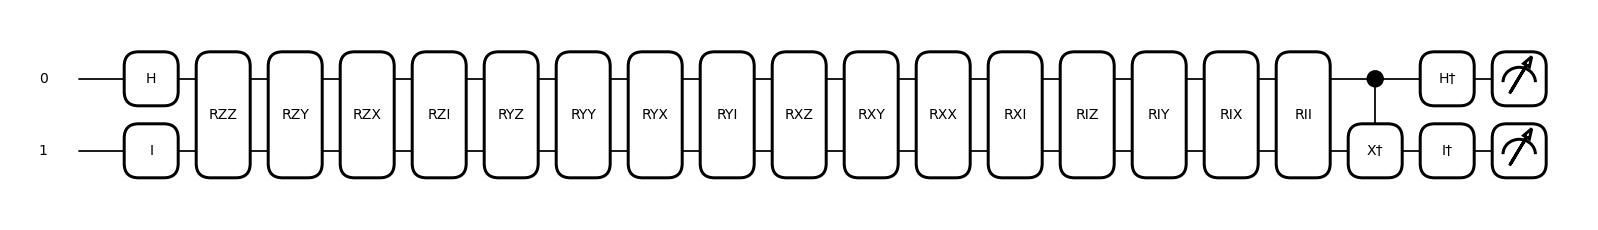

In [20]:
qml.draw_mpl(qc_sk)(*nn_theta(tf.constant([1.])),[0,4],qml.CNOT(wires=[0,1])) # input RZ RY RX RI H+ output measure

In [21]:
max_iterations = 300
conv_tol = 1e-10
# step_size = 0.1

optim = tf.keras.optimizers.Adam(learning_rate=0.01)
#optim = qml.QNGOptimizer(stepsize=0.1, approx="block-diag")

nn_param_history = [nn_theta(tf.constant([1.]))]
nn_cost_history = []

for epoch in range(1,max_iterations+1):
    with tf.GradientTape() as tape:
        loss_1 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[0,0],qml.CNOT(wires=[0,1]))[0]; # minimal basis 몇개?  6개/9개 (O)
        loss_2 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[0,4],qml.CNOT(wires=[0,1]))[0];
        loss_3 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[0,5],qml.CNOT(wires=[0,1]))[0];
        loss_4 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[4,0],qml.CNOT(wires=[0,1]))[0];
        loss_5 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[4,4],qml.CNOT(wires=[0,1]))[0];
        loss_6 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[4,5],qml.CNOT(wires=[0,1]))[0];
        loss_7 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[5,0],qml.CNOT(wires=[0,1]))[0];
        loss_8 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[5,4],qml.CNOT(wires=[0,1]))[0];
        loss_9 = 1.0 - qc_sk(*nn_theta(tf.constant([1.])),[5,5],qml.CNOT(wires=[0,1]))[0];


        loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9
    if len(nn_cost_history) > 0:
      conv = tf.abs(nn_cost_history[-1] - loss)
    else:
      conv = loss
    nn_cost_history.append(loss)
    gradients = tape.gradient(loss, nn_theta.trainable_variables);
    optim.apply_gradients(zip(gradients, nn_theta.trainable_variables));
    nn_param_history.append(nn_theta(tf.constant([1.])))
    # conv = tf.abs(tf_cost_fn(*nn_theta(tf.constant([1.]))) - loss)
    if conv <= conv_tol:
        break
    print("epoch: {}, loss: {}, convergence {}".format(epoch, loss, conv))

epoch: 1, loss: 4.911426896763506, convergence 4.911426896763506
epoch: 2, loss: 4.54373346050928, convergence 0.3676934362542257
epoch: 3, loss: 4.248620189332189, convergence 0.2951132711770912
epoch: 4, loss: 4.019242938360835, convergence 0.2293772509713543
epoch: 5, loss: 3.833436847522165, convergence 0.1858060908386694
epoch: 6, loss: 3.6739342502302184, convergence 0.15950259729194682
epoch: 7, loss: 3.528907742237655, convergence 0.14502650799256323
epoch: 8, loss: 3.390955050395375, convergence 0.1379526918422802
epoch: 9, loss: 3.256995067436022, convergence 0.13395998295935296
epoch: 10, loss: 3.1258683445886883, convergence 0.13112672284733362
epoch: 11, loss: 2.995885801571095, convergence 0.12998254301759316
epoch: 12, loss: 2.8644417381907945, convergence 0.13144406338030068
epoch: 13, loss: 2.7291985917222967, convergence 0.13524314646849778
epoch: 14, loss: 2.5885024066750066, convergence 0.1406961850472901
epoch: 15, loss: 2.4411412592304504, convergence 0.1473611474

In [22]:
# qc_sk(*nn_theta(tf.constant([1.])),[5],qml.Hadamard(wires=[0]))
qc_sk_mat = qml.matrix(qc_sk)(*nn_theta(tf.constant([1.])),[1],qml.S(wires=[0]));qc_sk_mat #qml matrix : 위의 circuit을 matrix form으로 바꿈

<tf.Tensor: shape=(4, 4), dtype=complex128, numpy=
array([[ 0.40777591+0.28934575j,  0.28937347-0.40775075j,
         0.40776867+0.28934859j, -0.28937259+0.40775701j],
       [ 0.2893642 -0.40775979j,  0.40775815+0.28937168j,
        -0.2893602 +0.40776516j,  0.40776257+0.28935372j],
       [ 0.4077638 +0.28935871j, -0.289383  +0.40774421j,
         0.4077713 +0.28934883j,  0.28937637-0.40775422j],
       [-0.2893619 +0.40775983j,  0.407762  +0.2893647j ,
         0.28936333-0.40776101j,  0.40775929+0.28936484j]])>

In [23]:
def generate_second_kind(eu):
  eu_fund = tf.constant(np.array([tf.reshape(Sigma(*s).fundamental,[2**eu.order,2**eu.order]) for s in eu.basis]),dtype=tf.complex128);
  dim = len(eu.basis)
  identity = tf.eye(2**eu.order,dtype=tf.complex128)
  @tf.function
  def second_kind(theta):
    c = tf.cast(tf.cos(theta/2),tf.complex128)
    s = tf.cast(2*tf.sin(theta/2),tf.complex128)
    ret = c[0] * identity + s[0] * eu_fund[0]
    for i in range(1,dim):
      ret = tf.matmul(ret,(c[i] * identity + s[i] * eu_fund[i]))
    return ret
  return second_kind

fn_sk = generate_second_kind(eu)

In [24]:
tf.matmul(fn_sk(*(nn_theta(tf.constant([1.])))),tf.linalg.adjoint(qc_sk_mat))

<tf.Tensor: shape=(4, 4), dtype=complex128, numpy=
array([[ 0.49823322+0.04200853j, -0.04199056+0.49823435j,
         0.49823155+0.04200235j,  0.04199701-0.4982324j ],
       [-0.04199632+0.49823386j,  0.49823413+0.04199776j,
         0.04198963-0.49823302j,  0.49823145+0.04200356j],
       [ 0.04201909-0.49823012j,  0.49823043+0.0420205j ,
        -0.04201326+0.49823284j,  0.49823124+0.04202721j],
       [ 0.49822995+0.04202622j,  0.04200823-0.49823104j,
         0.49823187+0.04201975j, -0.04201443+0.49823274j]])>

In [25]:
fn_sk(*(nn_theta(tf.constant([1.]))))

<tf.Tensor: shape=(4, 4), dtype=complex128, numpy=
array([[ 7.64035746e-01+6.45173819e-01j, -2.72243385e-06-2.10572145e-06j,
         4.26830403e-07-3.49457472e-06j,  6.24034408e-06+5.20982421e-06j],
       [ 2.53190011e-06+2.33141693e-06j,  7.64014723e-01+6.45198715e-01j,
         2.42709394e-07+2.07910897e-06j,  1.60401818e-06-8.80766702e-06j],
       [-6.18108571e-06-5.27993082e-06j,  8.41485164e-06-3.05582991e-06j,
         5.71206373e-06+7.90091154e-06j,  7.63994701e-01+6.45222423e-01j],
       [ 3.37380132e-06-1.00601176e-06j, -2.09047978e-06+1.08896516e-07j,
         7.64016828e-01+6.45196223e-01j, -8.74562683e-06-4.30875458e-06j]])>

In [26]:
h_gate = tf.cast(tf.constant([[1.,1.],[1.,-1.]])/tf.sqrt(2.),dtype=tf.complex128);
s_gate = tf.constant([[1,0],[0,-1.0j]],dtype=tf.complex128);
t_gate = tf.constant(np.array([[1,0],[0,np.exp(1.0j*np.pi/8)]],dtype=np.complex128));
cnot_gate = tf.constant(np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype=np.complex128));